# 'Diversity' mentions in the UC budget details

According to [this article](https://www.city-journal.org/html/less-academics-more-narcissism-10885.html) from 2011, at the time the UC system just experienced severe budget cuts, and yet "not only have diversity sinecures been protected from budget cuts, their numbers are actually growing."

I decided to investigate this by looking over the operating budget details for the UC system as [published by UCOP](http://ucop.edu/operating-budget/budgets-and-reports/current-operations-budgets/index.html).

The problem here is that I really didn't want to scour 10 documents that average over 200 pages each.  Instead, I decided to settle on a different metric -- the frequency of the occurrences of the word 'diversity' in each document.

## Methodology

I used `pdfgrep`, `pdftotext`, `pdfinfo`, `wc`, and `awk` to collect the data from the document.  Below are some sample commands.

    > for i in 20*.pdf; do pdftotext $i -; done | wc -w
    1051261

    > pdfgrep -i -c diversity 20*.pdf
    2008-09BudgRequestDetail.pdf:16
    2009-10BudgetforCurrentOperations-BudgetDetail.pdf:11
    2010-11BudgetforCurrentOperations-BudgetDetailrev.pdf:42
    2011-12-budget-detail.pdf:36
    2012-13-budget.pdf:35
    2013-14-budget.pdf:39
    2014-15budgetforcurrentoperations.pdf:40
    2015-16budgetforcurrentoperations_.pdf:50
    2016-17budgetforcurrentoperations.pdf:52
    2017-18budgetforcurrentoperations.pdf:63

    > for i in 20*.pdf; do pdfinfo $i | grep Pages | cut -d':' -f 2; done | awk '{sum += $1} END {print sum}'
    2146

There is an average of 489.87 words per page.  This was the divisor to calculate the 'diversity ratio' below.

## Results

|year | diversities | pages | diversities/page | diversity ratio |
|-----|-------------|-------|------------------|-----------------|
|2008 |          16 |   270 |            0.059 | 0.0001204       |
|2009 |          11 |   180 |            0.061 | 0.0001245       |
|2010 |          42 |   181 |            0.232 | 0.0004736       |
|2011 |          36 |   160 |            0.225 | 0.0004593       |
|2012 |          35 |   203 |            0.172 | 0.0003511       |
|2013 |          39 |   220 |            0.177 | 0.0003613       |
|2014 |          40 |   218 |            0.183 | 0.0003736       |
|2015 |          50 |   232 |            0.216 | 0.0004409       |
|2016 |          52 |   236 |            0.220 | 0.0004491       |
|2017 |          63 |   246 |            0.256 | 0.0004613       |

Curiously, there's a peak in 'diversities' mentions in 2010, appropriately the year before the article was written.  The mentions drop off to a local low in 2012 and steadily rise again from there.  What could this mean?

# Time for a linear regression!

Now, I'm not a data scientist, but I can cherry pick data and choose a model that supports my claims as well as anyone.  With that out of the way, what will happen if we fit a linear regression as a function of year, and year^2?

In [22]:
from sklearn import linear_model
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

diversity count per page: 491


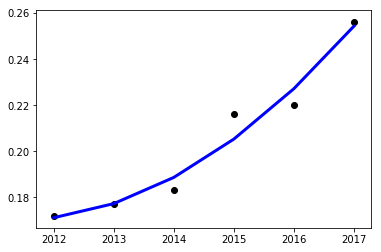

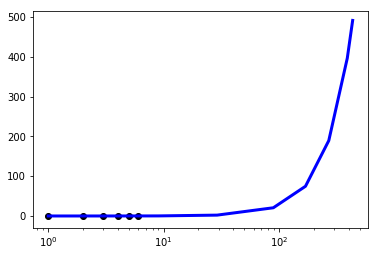

In [23]:
import numpy as np

# do year, year-squared starting in 2012 because that's where the consistent upward trend starts
years = np.array(range(2012, 2018))
normalized_years = np.array([i - 2011 for i in years])
X2 = np.array([[i, i**2] for i in years])
y = np.array([0.172, 0.177, 0.183, 0.216, 0.220, 0.256])

lr2 = linear_model.LinearRegression(normalize=True)
lr2.fit(X2, y)
# total diversity saturation here
SATURATION_YEAR = 2444
predict_years = np.array(range(2012,2018) + [2020, 2040, 2100, 2180, 2280, 2400, SATURATION_YEAR])
predict_norm_years = np.array([i - 2011 for i in predict_years])
predict_X2 = np.array([[i, i**2] for i in predict_years])
print "diversity count per page: %i" % lr2.predict([[SATURATION_YEAR, SATURATION_YEAR**2]])[0]
plt.plot(years, lr2.predict(X2), color='blue', linewidth=3)
plt.scatter(years, y, color='black')
plt.show()
plt.plot(predict_norm_years, lr2.predict(predict_X2), color='blue', linewidth=3)
plt.scatter(normalized_years, y, color='black')
plt.xscale('log')
plt.show()

In [24]:
print lr2.coef_, lr2.intercept_

[ -1.05594964e+01   2.62500000e-03] 10619.4999929


## Now with normalization and more features

Let's be a bit more rigorous here. We can't fake being a data scientist if we don't do validation and hyperparameter tuning.

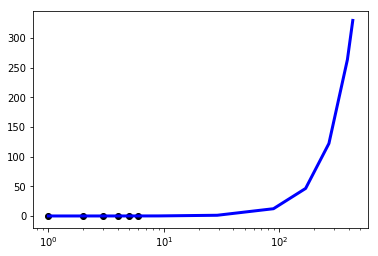

In [25]:
from math import sqrt

feat_extract = lambda x: [x**(1.0+i/10.0) for i in range(0,31)]

lr_norm = linear_model.LassoCV(normalize=True)
features = np.array([feat_extract(i) for i in normalized_years])
lr_norm.fit(features, y)
predict_features = [feat_extract(i) for i in predict_norm_years]
plt.plot(predict_norm_years, lr_norm.predict(predict_features), color='blue', linewidth=3)
# plt.plot(normalized_years, lr_norm.predict(features), color='blue', linewidth=3)
plt.scatter(normalized_years, y, color='black')
plt.xscale('log')
plt.show()

In [26]:
print lr_norm.alpha_, lr_norm.coef_, lr_norm.intercept_
print ''

print lr_norm.intercept_,
coef = lr_norm.coef_
for i in range(len(coef)):
    if coef[i] == 0:
        continue
    print " + %fx^%.1f" % (coef[i], 1.0 + i/10.0),
print ''

0.00552213417086 [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.00060701  0.00042662  0.00010911
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] 0.184993075042

0.184993075042  + 0.000607x^2.0  + 0.000427x^2.1  + 0.000109x^2.2 


In [27]:
j = 2100
prediction = 0
while True:
    prediction = lr_norm.predict([feat_extract(j - 2011)])[0]
    if prediction > 490:
        break
    j += 1
print j, prediction

2535 490.76198172


In [28]:
print("Training error: %.8f" % np.mean((lr_norm.predict(features) - np.array(y)) ** 2))

Training error: 0.00021675


## Conclusion

By the year 2535, the entire UC budget details document will consist entirely of the word 'diversity' repeated ad nauseam.

Hmm, that doesn't seem right.  Maybe I should've used a multilayer perceptron instead.